# K-means demographic labeling

This notebook was created to show why k-means clustering was ultimately not used for this analysis. It is a test notebook and contains personal notes. It was not and will not be improved upon in the future.

Code for this notebook was strongly inspired if not copied from:

https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans

In [9]:
import pandas as pd
import numpy as np

ads_df = pd.read_csv('../clean_data/clean_data.csv', parse_dates=['ad_creation_date', 'ad_end_date'])
ads_df.head(3)

,file_name,ad_targeting_interests,ad_impressions,ad_clicks,ad_spend,ad_creation_date,ad_end_date
0,P(1)0002823.txt,"Pan-Africanism, African-American Civil Rights...",10496,1823,200.00,2017-04-21,2017-04-22
1,P(1)0002837.txt,"Pan-Africanism, African-American Civil Rights...",16305,1337,499.49,2017-04-13,2017-04-14
2,P(1)0006304.txt,"Martin Luther King, Jr., Stop Racism!!, Afric...",8210,1788,1570.03,2017-05-29,2017-05-29


We will be using scikit learn to extract features using a technique called tfidf. (Term Frequency - Inverse Document Frequency) As per it's [wikipedia entry](https://en.wikipedia.org/wiki/Tf%E2%80%93idf):

>The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

The Tfid method requires our data to be vectorized by creating a feature vector of length vocabulary determined by the number of distinct words found in all rows of the ad_targeting_interests column. In the interest of time, we will be using scikit's TfidVectorizer with the stop_words option so that punctuation and words such as 'and' and 'or' get pruned automatically. This approach is not perfect as it also removes hyphens which are used fairly frequently to join words in this dataset.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=8000)
vectorizer.fit(ads_df.ad_targeting_interests)
text = vectorizer.transform(ads_df.ad_targeting_interests)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters


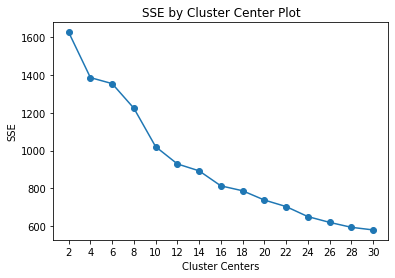

In [6]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 30)

clusters = MiniBatchKMeans(n_clusters=20, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

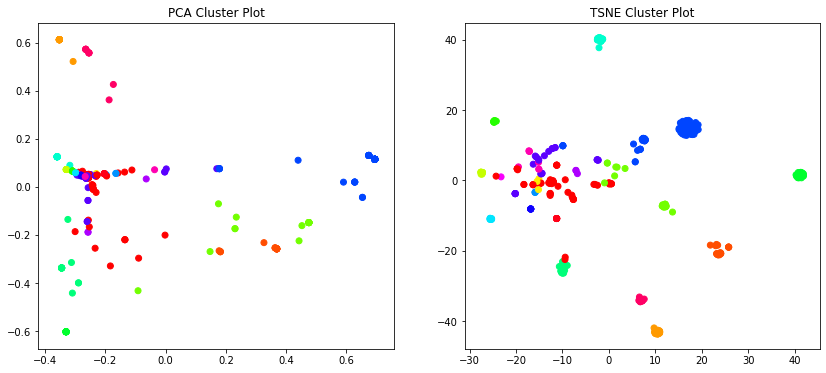

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=700, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=20).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [8]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, vectorizer.get_feature_names(), 10)


Cluster 0
rock,stop,donald,trump,funny,social,justice,human,beautiful,black

Cluster 1
stop,movement,consciousness,nationalism,misconduct,brutality,american,african,black,police

Cluster 2
raza,la,latin,hispanidad,lowrider,hop,hip,mexico,rap,chicano

Cluster 3
palestine,muhammad,mosque,world,muslims,islam,islamism,terrorists,brotherhood,muslim

Cluster 4
movements,territory,pride,gay,sex,marriage,homosexuality,community,united,lgbt

Cluster 5
civil,68,1954,pan,africanism,color,history,american,african,black

Cluster 6
flag,flags,fly,fm,follow,foramerica,firearm,zion,patriotism,independence

Cluster 7
fly,fm,follow,foramerica,forces,foreign,fitness,zion,black,matters

Cluster 8
tea,patriots,knowledge,color,politics,black,com,blacknews,voices,huffpost

Cluster 9
fm,follow,foramerica,forces,fitness,zion,imgur,collegehumor,9gag,buzzfeed

Cluster 10
flag,flags,fly,fm,follow,foramerica,forces,foundation,don,shoot

Cluster 11
news,online,movement,american,nation,wisdom,language,native,cherok

It is difficult to associate one cluster to one demographic. For instance Clusters 1, 5 and 12 contain the word African. 6, 7, 10 and 13 contain the sequence fly,fm,follow,foramerica. Additionaly cluster 2 and 18 seem to treat of Mexian related topics...